In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
pd.options.display.float_format = '{:,.4f}'.format
N_JOBS = -1
DERIVE_FEATURES=True
HANDLE_OUTLIERS=True
USE_HIGH_CHURN=False
VERBOSITY=0
PRED_FOLDER='./'
CREATE_SUBMISSION_CSV=True

In [2]:
# Functions
def same_columns(dfin):
    same_columns = {}
    for c in dfin.columns:
        if dfin[c].value_counts().shape[0] == 1:
            same_columns[c] = list(dfin[c].unique())
    return same_columns

def find_columns_with_nans(dfin):
    _dfnans = pd.DataFrame()
    _dfnans['counts'] = dfin[dfin.columns[dfin.isnull().any()]].isnull().sum()
    _dfnans['perc'] = 100 * _dfnans['counts'] / dfin.shape[0]
    _dfnans = _dfnans.reset_index()
    _dfnans['uniq_counts'] = _dfnans['index'].apply(lambda x: len(dfin[x].unique()))
    _dfnans['dtype'] = _dfnans['index'].apply(lambda x: dfin[x].dtype)
    return _dfnans

def drop_columns_with_nans(dfin, perc=40, drop_cols=True):
    too_many_nans = dfin[dfin.columns[dfin.isnull().sum() * 100 / dfin.shape[0] > perc]].columns.tolist()
    print(f"Cols with {perc}% or more nans: {len(too_many_nans)}")
    if drop_cols:
        dfin = dfin.drop(too_many_nans, axis=1)
        print(f"After dropping: {dfin.shape}")
    return dfin, too_many_nans

def get_redundant_pairs(_df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = _df.columns
    for i in range(0, _df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(_df, n=5):
    au_corr = _df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def remove_outliers(arr, k=3):
    upper_limit = arr.mean() + k*arr.std()
    lower_limit = arr.mean() - k*arr.std()
    arr[arr<lower_limit] = lower_limit
    arr[arr>upper_limit] = upper_limit
    return arr

def get_gridcv_results(mdl):
    res = pd.DataFrame.from_dict(mdl.cv_results_)
    to_drop = []
    for col in res.columns:
        if col.endswith('_time'):
            to_drop.append(col)
    res = res.drop(to_drop, axis=1)
    res = res.transpose()
    return res

def get_feature_importance(mdl, features, mul=100):
    importance = mdl.feature_importances_
    # create dataframe
    feature_importance = \
        pd.DataFrame({'variables': features, 'importance_percentage': importance*mul})
    feature_importance = feature_importance[['variables', 'importance_percentage']]

    # sort features
    feature_importance = \
        feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
    feature_importance['cumulative_importance'] = feature_importance['importance_percentage'].cumsum()
    print("Sum of importance=", feature_importance.importance_percentage.sum())
    return feature_importance

In [3]:
df = pd.read_csv("./train.csv", low_memory=False)
df.shape

(69999, 172)

In [4]:
dft = pd.read_csv("./test.csv", low_memory=False)
dft.shape

(30000, 171)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [6]:
for c in df.columns:
    print(f'{c.ljust(25)}: {str(df[c].dtype).rjust(10)}  {len(df[c].unique())}')


id                       :      int64  69999
circle_id                :      int64  1
loc_og_t2o_mou           :    float64  2
std_og_t2o_mou           :    float64  2
loc_ic_t2o_mou           :    float64  2
last_date_of_month_6     :     object  1
last_date_of_month_7     :     object  2
last_date_of_month_8     :     object  2
arpu_6                   :    float64  61615
arpu_7                   :    float64  61425
arpu_8                   :    float64  60194
onnet_mou_6              :    float64  20058
onnet_mou_7              :    float64  20077
onnet_mou_8              :    float64  19726
offnet_mou_6             :    float64  26255
offnet_mou_7             :    float64  26140
offnet_mou_8             :    float64  25996
roam_ic_mou_6            :    float64  5307
roam_ic_mou_7            :    float64  4241
roam_ic_mou_8            :    float64  4253
roam_og_mou_6            :    float64  6569
roam_og_mou_7            :    float64  5306
roam_og_mou_8            :    float64  5216

In [7]:
col_names_only = []
for c in df.columns:
    stripped = c
    if c.endswith('_6') or c.endswith('_7') or c.endswith('_8'):
        stripped = c[:-2]
    if stripped not in col_names_only:
        col_names_only.append(stripped)
        print(stripped, len(col_names_only))

id 1
circle_id 2
loc_og_t2o_mou 3
std_og_t2o_mou 4
loc_ic_t2o_mou 5
last_date_of_month 6
arpu 7
onnet_mou 8
offnet_mou 9
roam_ic_mou 10
roam_og_mou 11
loc_og_t2t_mou 12
loc_og_t2m_mou 13
loc_og_t2f_mou 14
loc_og_t2c_mou 15
loc_og_mou 16
std_og_t2t_mou 17
std_og_t2m_mou 18
std_og_t2f_mou 19
std_og_t2c_mou 20
std_og_mou 21
isd_og_mou 22
spl_og_mou 23
og_others 24
total_og_mou 25
loc_ic_t2t_mou 26
loc_ic_t2m_mou 27
loc_ic_t2f_mou 28
loc_ic_mou 29
std_ic_t2t_mou 30
std_ic_t2m_mou 31
std_ic_t2f_mou 32
std_ic_t2o_mou 33
std_ic_mou 34
total_ic_mou 35
spl_ic_mou 36
isd_ic_mou 37
ic_others 38
total_rech_num 39
total_rech_amt 40
max_rech_amt 41
date_of_last_rech 42
last_day_rch_amt 43
date_of_last_rech_data 44
total_rech_data 45
max_rech_data 46
count_rech_2g 47
count_rech_3g 48
av_rech_amt_data 49
vol_2g_mb 50
vol_3g_mb 51
arpu_3g 52
arpu_2g 53
night_pck_user 54
monthly_2g 55
sachet_2g 56
monthly_3g 57
sachet_3g 58
fb_user 59
aon 60
aug_vbc_3g 61
jul_vbc_3g 62
jun_vbc_3g 63
churn_probability 64

In [8]:
df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0000,0.0000,0.0000,6/30/2014,7/31/2014,8/31/2014,31.2770,87.0090,...,0,0,nan,nan,nan,1958,0.0000,0.0000,0.0000,0
1,1,109,0.0000,0.0000,0.0000,6/30/2014,7/31/2014,8/31/2014,0.0000,122.7870,...,0,0,nan,1.0000,nan,710,0.0000,0.0000,0.0000,0
2,2,109,0.0000,0.0000,0.0000,6/30/2014,7/31/2014,8/31/2014,60.8060,103.1760,...,0,0,nan,nan,nan,882,0.0000,0.0000,0.0000,0
3,3,109,0.0000,0.0000,0.0000,6/30/2014,7/31/2014,8/31/2014,156.3620,205.2600,...,0,0,nan,nan,nan,982,0.0000,0.0000,0.0000,0
4,4,109,0.0000,0.0000,0.0000,6/30/2014,7/31/2014,8/31/2014,240.7080,128.1910,...,1,0,1.0000,1.0000,1.0000,647,0.0000,0.0000,0.0000,0


## Find column types

In [9]:
df.shape

(69999, 172)

In [10]:
dropped_columns = []
id_columns = ['id', 'circle_id']
df = df.drop(id_columns, axis=1)
df.shape

(69999, 170)

In [11]:
all_columns = list(df.columns)
date_columns = []
def get_cols_by_name(name):
    arr = []
    for c in all_columns:
        if name in c:
            arr.append(c)
    return arr
datecols = get_cols_by_name("date")
print(len(datecols))

9


In [12]:
# number of columns with missing values
dfnans = find_columns_with_nans(df)
dfnans.shape

(125, 5)

In [13]:
recharge_columns = [ x for x in list(dfnans['index']) if "rech" in x ]

recharge_columns_no_date = [x for x in recharge_columns if not "date" in x]
print('\nrecharge_columns_no_date')
print(recharge_columns_no_date)

only_dates = [x for x in recharge_columns if "date" in x]
print('\nonly_dates')
print(only_dates)


recharge_columns_no_date
['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']

only_dates
['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']


### We assume missing values in recharge columns are same as 0

In [14]:
df[recharge_columns_no_date] = df[recharge_columns_no_date].apply(lambda x: x.fillna(0))

In [15]:
dfn2 = find_columns_with_nans(df)
dfn2.shape

(110, 5)

In [16]:
# impute missing values in recharge date with May 1, 2014
print(df.shape)
data_dates = ['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8']
rech_dates = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']
df = df.drop(data_dates, axis=1)
import datetime
for dtc in rech_dates:
    df[dtc] = pd.to_datetime(df[dtc])
    df[dtc] = df[dtc].fillna(datetime.datetime(2014, 5, 1))
    df[dtc] = (datetime.datetime(2014, 9, 5) - df[dtc]).dt.days
    print(dtc, df[dtc].max(), df[dtc].isnull().sum())
print(df.shape)

(69999, 170)
date_of_last_rech_6 127 0
date_of_last_rech_7 127 0
date_of_last_rech_8 127 0
(69999, 167)


In [17]:
last_date_cols = ['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8']
df = df.drop(last_date_cols, axis=1)
df.shape

(69999, 164)

In [18]:
dfn3 = find_columns_with_nans(df)
dfn3.shape

(102, 5)

### for night_* and fb_user_* impute with -1

In [19]:
fb_night_cols = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
df[fb_night_cols] = df[fb_night_cols].apply(lambda x: x.fillna(-1))

In [20]:
dfn4 = find_columns_with_nans(df)
dfn4.shape

(96, 5)

### Drop columns with more than 40% nans

In [21]:
df.shape

(69999, 164)

In [22]:
df, cols_with_nans = drop_columns_with_nans(df)
df.shape

Cols with 40% or more nans: 6
After dropping: (69999, 158)


(69999, 158)

### Impute remaining missing values with median

In [23]:
dfn5 = find_columns_with_nans(df)
impute_values = {}
for i,col in enumerate(list(dfn5['index'])):
    if df[col].dtype == np.float64 or df[col].dtype == np.int64:
        print(f'{col}, float, impute with: {df[col].median():.2f}')
        df[col] = df[col].fillna(df[col].median())
        impute_values[col] = df[col].median()
    else:
        df[col] = df[col].fillna(df[col].mode(dropna=True)[0])
dfn5.shape

loc_og_t2o_mou, float, impute with: 0.00
std_og_t2o_mou, float, impute with: 0.00
loc_ic_t2o_mou, float, impute with: 0.00
onnet_mou_6, float, impute with: 34.11
onnet_mou_7, float, impute with: 32.28
onnet_mou_8, float, impute with: 32.10
offnet_mou_6, float, impute with: 96.48
offnet_mou_7, float, impute with: 91.88
offnet_mou_8, float, impute with: 91.80
roam_ic_mou_6, float, impute with: 0.00
roam_ic_mou_7, float, impute with: 0.00
roam_ic_mou_8, float, impute with: 0.00
roam_og_mou_6, float, impute with: 0.00
roam_og_mou_7, float, impute with: 0.00
roam_og_mou_8, float, impute with: 0.00
loc_og_t2t_mou_6, float, impute with: 11.91
loc_og_t2t_mou_7, float, impute with: 11.58
loc_og_t2t_mou_8, float, impute with: 11.74
loc_og_t2m_mou_6, float, impute with: 41.03
loc_og_t2m_mou_7, float, impute with: 40.17
loc_og_t2m_mou_8, float, impute with: 40.35
loc_og_t2f_mou_6, float, impute with: 0.00
loc_og_t2f_mou_7, float, impute with: 0.00
loc_og_t2f_mou_8, float, impute with: 0.00
loc_og_

(90, 5)

In [24]:
find_columns_with_nans(df)

,index,counts,perc,uniq_counts,dtype


#### No more missing values

In [25]:
df.shape

(69999, 158)

In [26]:
sc = same_columns(df)
sc

{'loc_og_t2o_mou': [0.0],
 'std_og_t2o_mou': [0.0],
 'loc_ic_t2o_mou': [0.0],
 'std_og_t2c_mou_6': [0.0],
 'std_og_t2c_mou_7': [0.0],
 'std_og_t2c_mou_8': [0.0],
 'std_ic_t2o_mou_6': [0.0],
 'std_ic_t2o_mou_7': [0.0],
 'std_ic_t2o_mou_8': [0.0]}

In [27]:
same_cols = sc.keys()
df = df.drop(same_cols,axis=1)
df.shape

(69999, 149)

### Check churn probability

In [28]:
df['churn_probability'].value_counts() / df.shape[0]

0   0.8981
1   0.1019
Name: churn_probability, dtype: float64

- churn probability is imbalanced
- Only 10% data shows churing customers
- We will use stratified split and other strategies to handle

## Process test data
apply same transformations on test data as train data

In [29]:
dfnoy = df.drop("churn_probability", axis = 1)
train_cols = list(dfnoy.columns)

In [30]:
dftid = pd.DataFrame()
dftid['id'] = dft['id']

In [31]:
dft = dft.filter(train_cols,axis=1)
dft.shape

(30000, 148)

In [32]:
for dtc in rech_dates:
    dft[dtc] = pd.to_datetime(dft[dtc])
    dft[dtc] = dft[dtc].fillna(datetime.datetime(2014, 5, 1))
    dft[dtc] = (datetime.datetime(2014, 9, 5) - dft[dtc]).dt.days
    print(dtc, dft[dtc].max(), dft[dtc].isnull().sum())
print(dft.shape)

date_of_last_rech_6 127 0
date_of_last_rech_7 127 0
date_of_last_rech_8 127 0
(30000, 148)


In [33]:
find_columns_with_nans(dft)

,index,counts,perc,uniq_counts,dtype
0,onnet_mou_6,1169,3.8967,12284,float64
1,onnet_mou_7,1172,3.9067,12177,float64
2,onnet_mou_8,1675,5.5833,12055,float64
3,offnet_mou_6,1169,3.8967,16383,float64
4,offnet_mou_7,1172,3.9067,16152,float64
...,...,...,...,...,...
97,night_pck_user_7,22294,74.3133,3,float64
98,night_pck_user_8,22078,73.5933,3,float64
99,fb_user_6,22415,74.7167,3,float64
100,fb_user_7,22294,74.3133,3,float64


In [34]:
dft[recharge_columns_no_date] = dft[recharge_columns_no_date].apply(lambda x: x.fillna(0))

In [35]:
dft[fb_night_cols] = dft[fb_night_cols].apply(lambda x: x.fillna(-1))

In [36]:
for col, v in impute_values.items():
    if col in dft.columns:
        dft[col] = dft[col].fillna(v)

In [37]:
find_columns_with_nans(dft)

,index,counts,perc,uniq_counts,dtype


#### No more missing values

## EDA

In [38]:
#  plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(var1, var2)

In [39]:
categoricals = []
ints = []
floats = []
numericals = []
for col in df.columns:
    if df[col].dtype == np.int64:
        ints.append(col)
        numericals.append(col)
    elif df[col].dtype == np.float64:
        floats.append(col)
        numericals.append(col)
    else:
        categoricals.append(col)
print(f'cat: {len(categoricals)} floats: {len(floats)} ints: {len(ints)}')

cat: 0 floats: 120 ints: 29


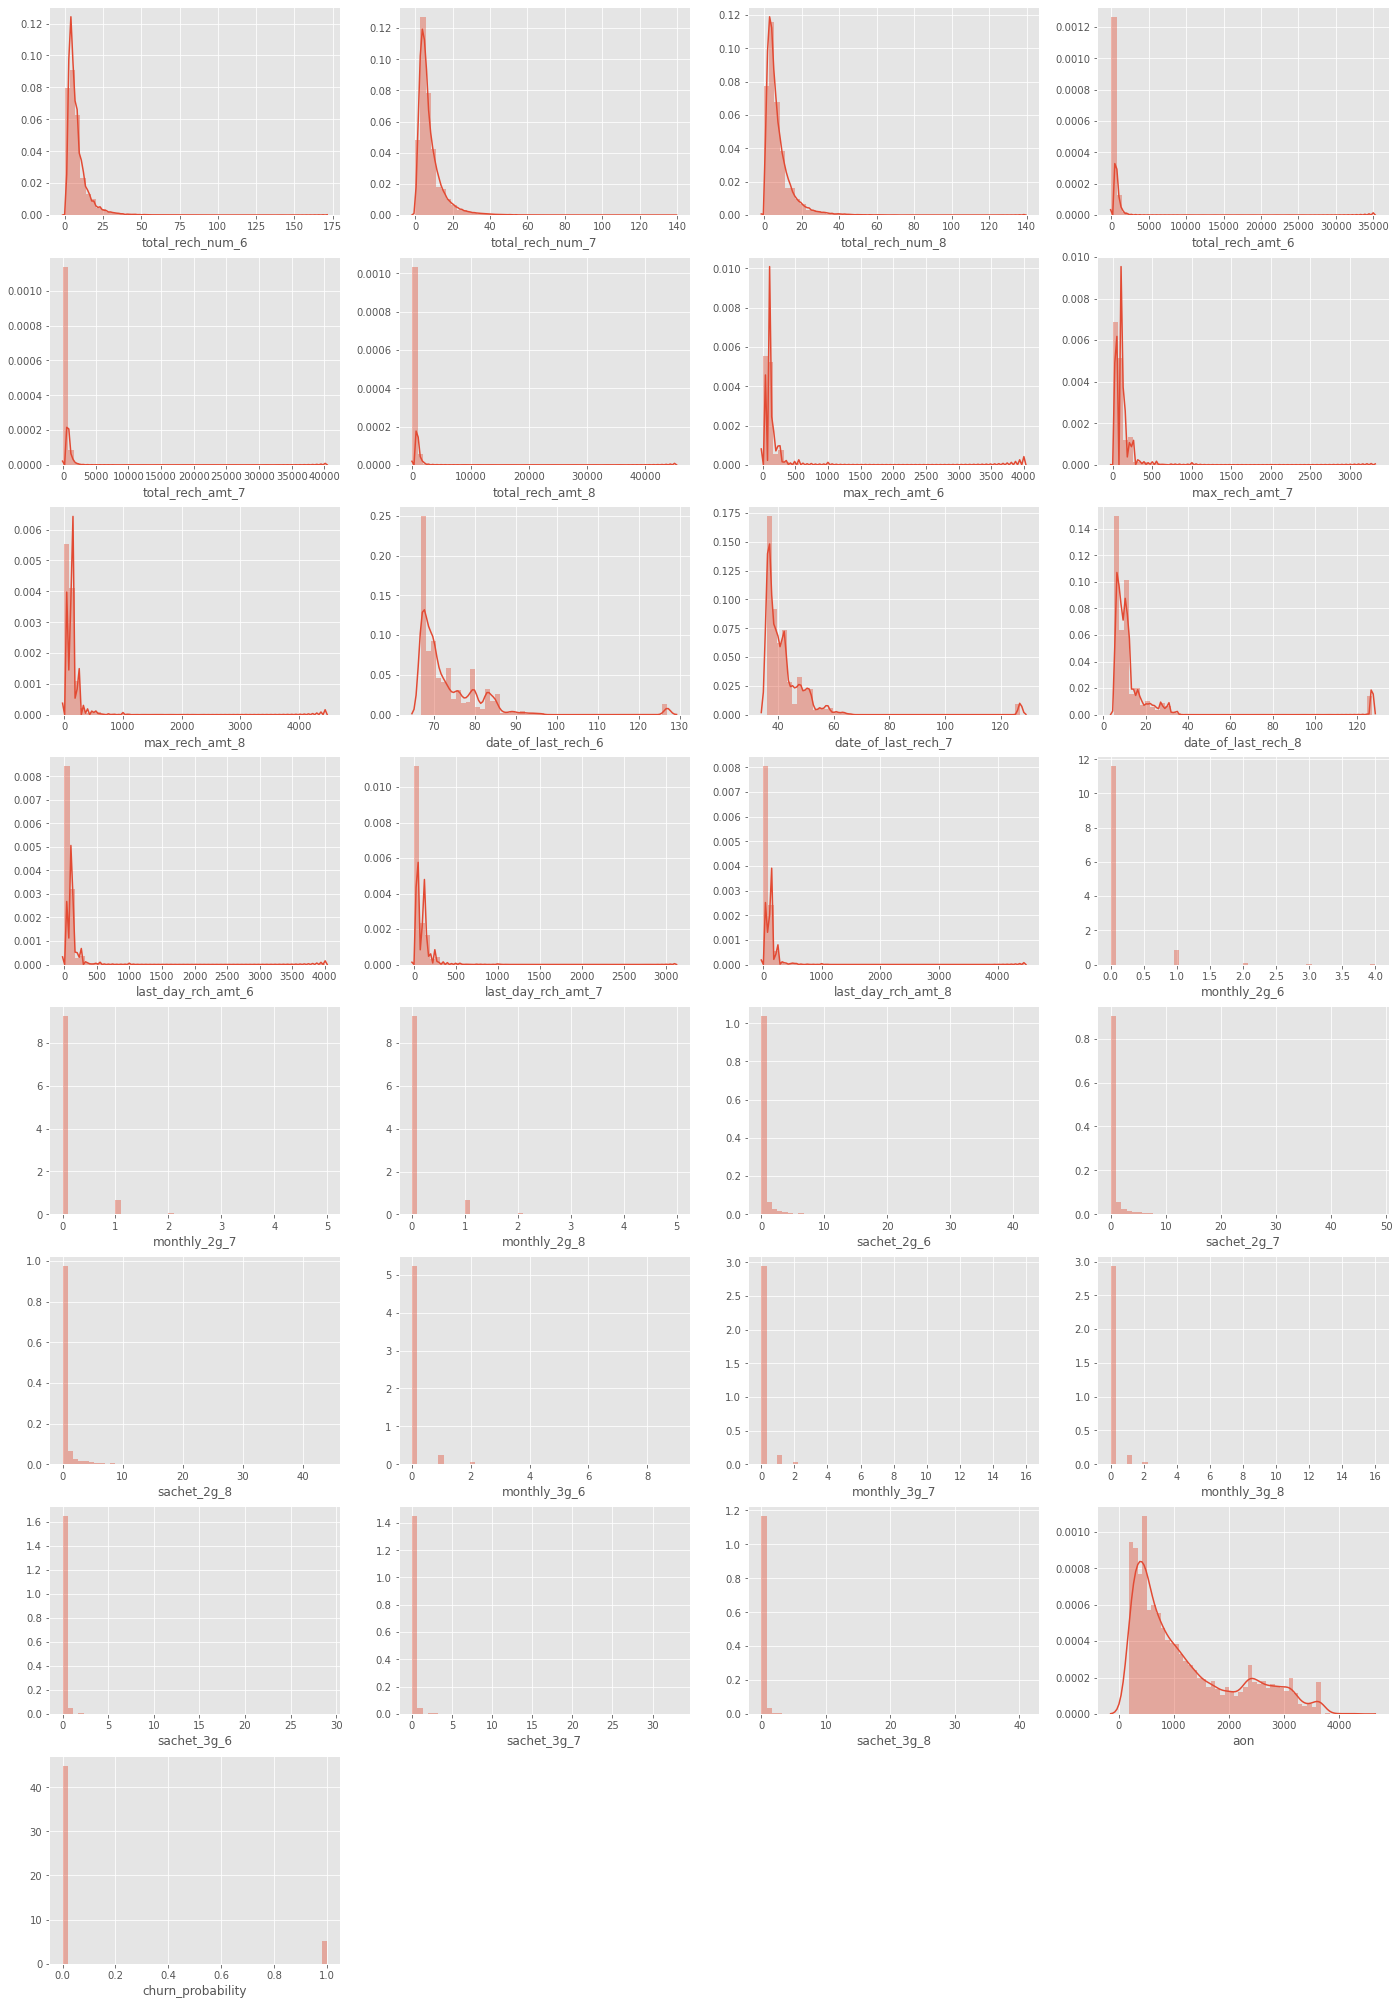

In [40]:
plt.figure(figsize=(24, 36))
i = 0
for col in ints:  
    i+=1
    plt.subplot(8,4,i)
    sns.distplot(df[col])


Most integer type variables are skewed

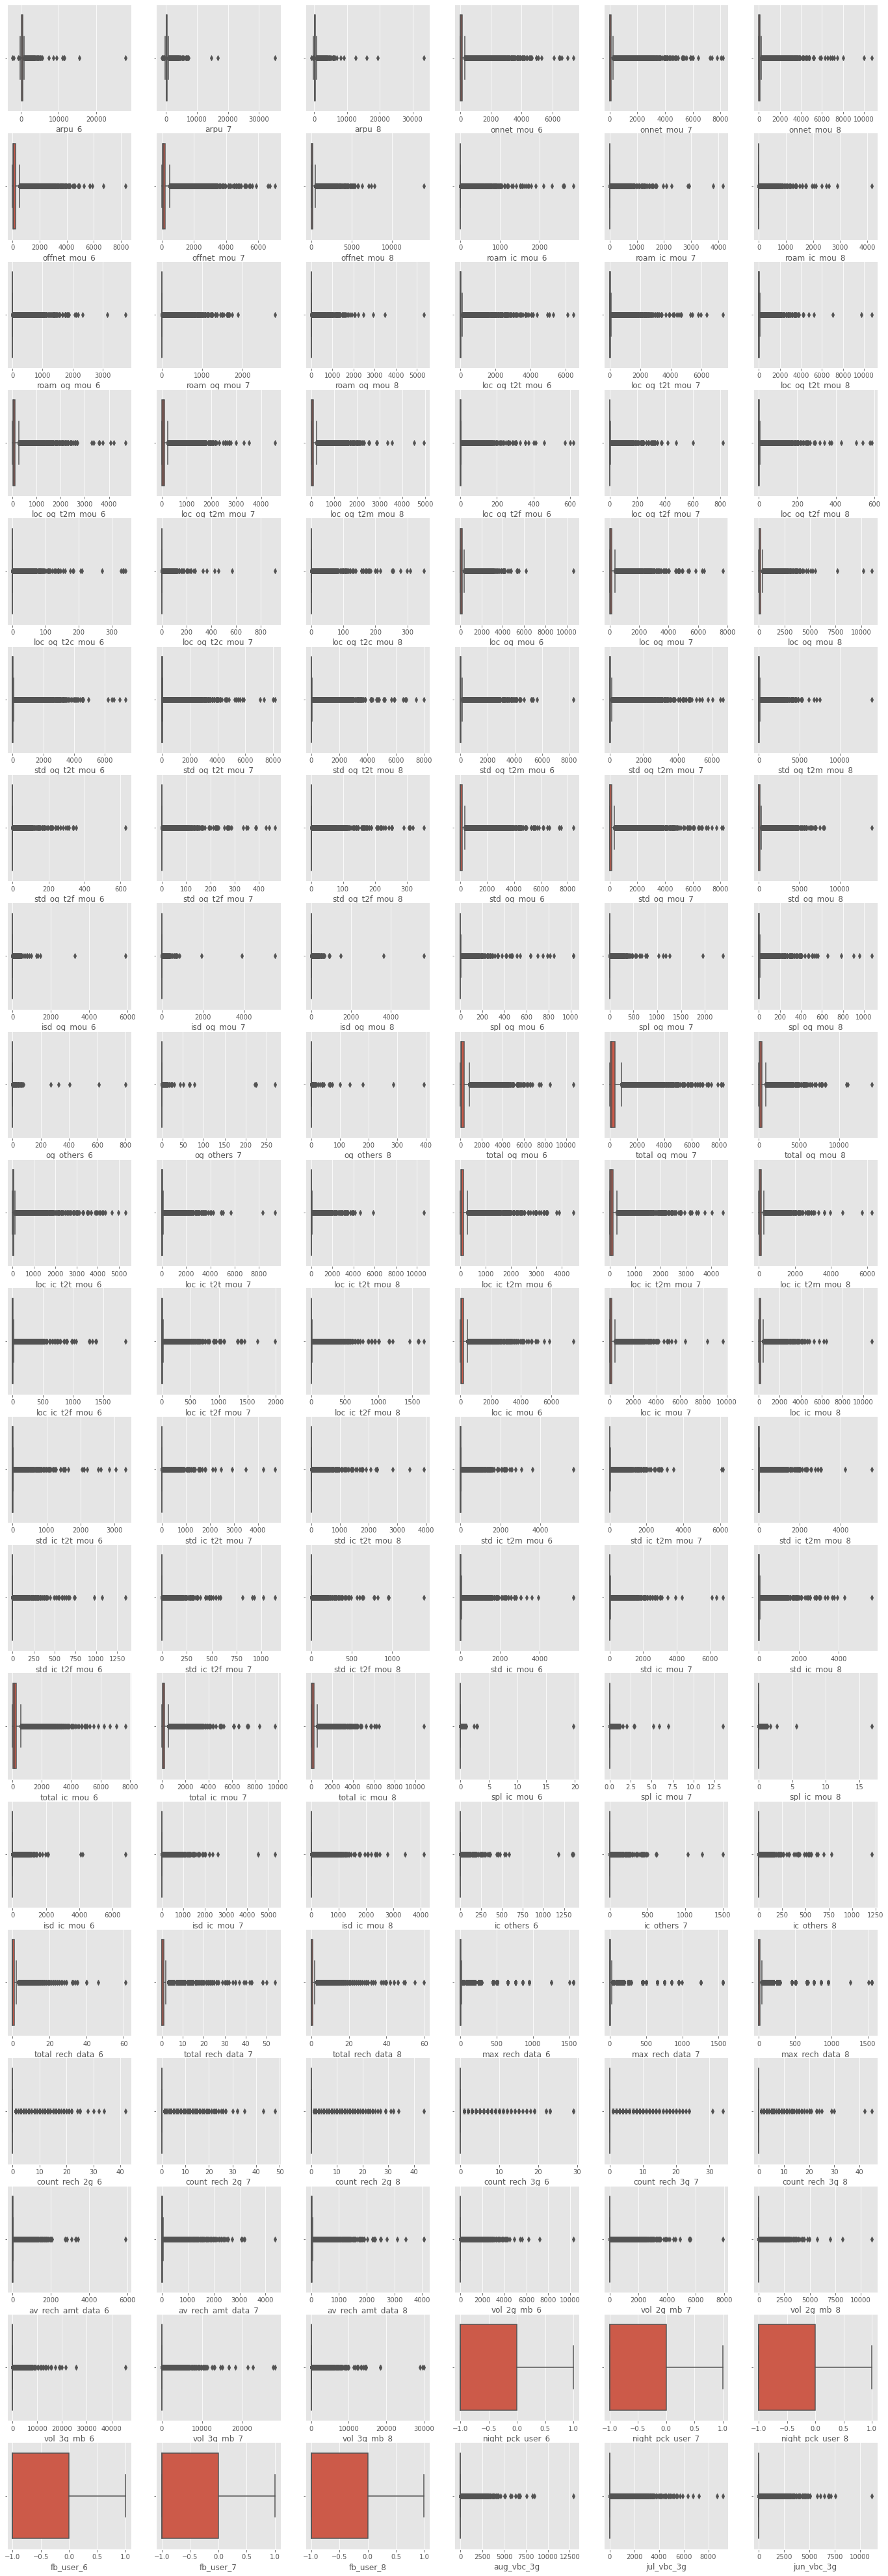

In [41]:
plt.figure(figsize=(24, 72))
i = 0
for col in floats:  
    i+=1
    plt.subplot(20,6,i)
    sns.boxplot(df[col])
plt.show()

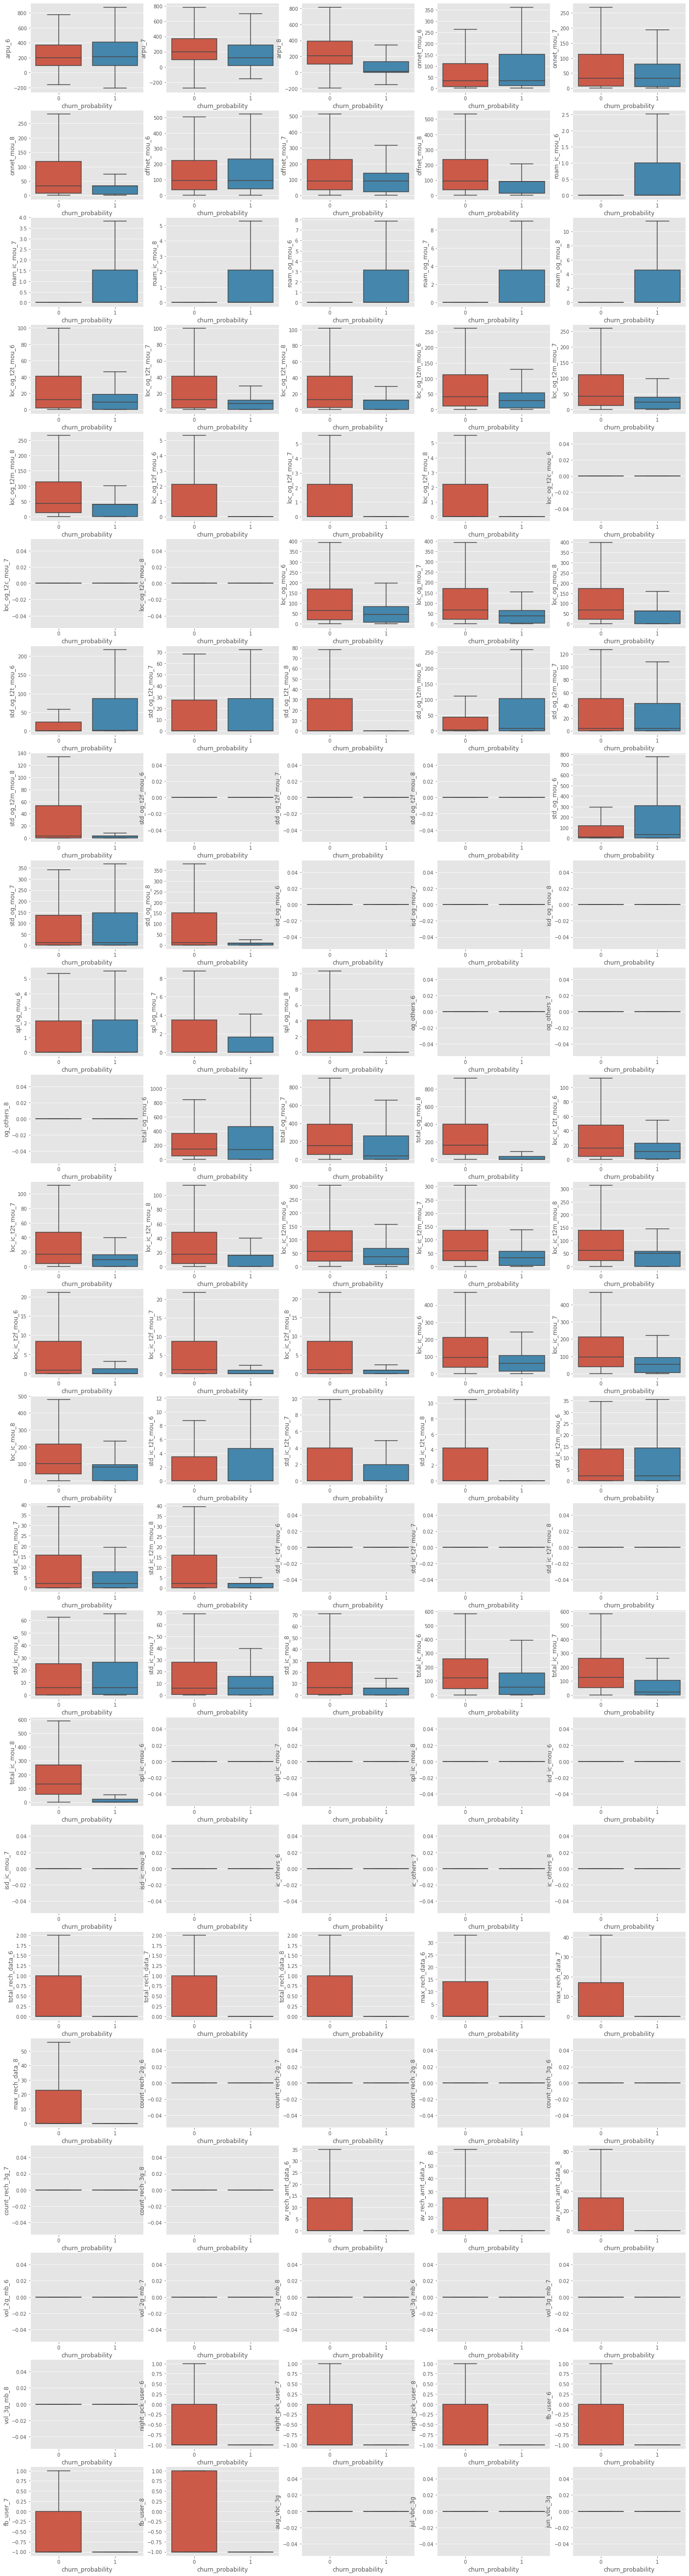

In [42]:
plt.figure(figsize=(24, 96))
i = 0
for col in floats:  
    i+=1
    plt.subplot(24,5,i)
    sns.boxplot(df['churn_probability'], df[col], showfliers=False)
plt.show()

#### All float variables have outliers - these will have to be treated

In [43]:
df = df.reset_index(drop=True)
dfcorr = df.corr()

In [44]:
# Following code takes a long time to run - hence commented out
# plt.figure(figsize=(24, 24))
# sns.heatmap(dfcorr, 
#             xticklabels = dfcorr.columns.values,
#             yticklabels = dfcorr.columns.values,
#             vmin = -1.0, vmax = 1.0,
#             annot = False, cmap="RdYlGn");
# plt.show()

### Derive some features as discussed in session

In [45]:
for_derived_feats = ["arpu", "onnet_mou", "offnet_mou", "roam_ic_mou", "roam_og_mou", "loc_og_mou", "std_og_mou", 
 "isd_og_mou", "spl_og_mou", "total_og_mou", "loc_ic_mou", "std_ic_mou", "isd_ic_mou", "spl_ic_mou", 
 "total_ic_mou", "total_rech_num", "total_rech_amt", "max_rech_amt", "total_rech_data", 
 "max_rech_data", "av_rech_amt_data", "vol_2g_mb", "vol_3g_mb"]

if DERIVE_FEATURES:
    added_features = []
    print(df.shape)
    for c in for_derived_feats:
        c_diff, c6, c7, c8 = c + "_diff", c + "_6", c + "_7", c + "_8"
        added_features.append(c_diff)
        print(c_diff)
        df[c_diff] = df[c8] - (df[c6] + df[c7])/2
    print(df.shape)

    print(dft.shape)
    for c in for_derived_feats:
        c_diff, c6, c7, c8 = c + "_diff", c + "_6", c + "_7", c + "_8"
    #     print(c_diff, c6, c7, c8)
        dft[c_diff] = dft[c8] - (dft[c6] + dft[c7])/2
    print(dft.shape)

(69999, 149)
arpu_diff
onnet_mou_diff
offnet_mou_diff
roam_ic_mou_diff
roam_og_mou_diff
loc_og_mou_diff
std_og_mou_diff
isd_og_mou_diff
spl_og_mou_diff
total_og_mou_diff
loc_ic_mou_diff
std_ic_mou_diff
isd_ic_mou_diff
spl_ic_mou_diff
total_ic_mou_diff
total_rech_num_diff
total_rech_amt_diff
max_rech_amt_diff
total_rech_data_diff
max_rech_data_diff
av_rech_amt_data_diff
vol_2g_mb_diff
vol_3g_mb_diff
(69999, 172)
(30000, 148)
(30000, 171)


These features show how usage differs in the last month vs the previous 2 months

Use One-hot encoding for facebook and night use

In [46]:
df = pd.get_dummies(df, columns=fb_night_cols, prefix=fb_night_cols, drop_first=False)
df.shape

dft = pd.get_dummies(dft, columns=fb_night_cols, prefix=fb_night_cols, drop_first=False)
dft.shape

(30000, 183)

### High Value customers

In [47]:
# Data recharge amt
df['total_rech_amt_data_6'] = df['total_rech_data_6'] * df['av_rech_amt_data_6']
df['total_rech_amt_data_7'] = df['total_rech_data_7'] * df['av_rech_amt_data_7']
df['total_rech_amt_d_6'] = df['total_rech_amt_6'] + df['total_rech_amt_data_6']
df['total_rech_amt_d_7'] = df['total_rech_amt_7'] + df['total_rech_amt_data_7']
df['av_rech_amt_data_6_7'] = (df['total_rech_amt_d_6'] + df['total_rech_amt_d_7'])/2

print(df['av_rech_amt_data_6_7'].quantile(0.7))
dfh = df.loc[df['av_rech_amt_data_6_7'] >= df['av_rech_amt_data_6_7'].quantile(0.7), :]
print(dfh.shape)
print(dfh['churn_probability'].value_counts() / dfh.shape[0])
dfh = dfh.drop(['total_rech_amt_data_6', 'total_rech_amt_data_7', 
                'total_rech_amt_d_6', 'total_rech_amt_d_7', 'av_rech_amt_data_6_7'], axis=1)

df = df.drop(['total_rech_amt_data_6', 'total_rech_amt_data_7', 
                'total_rech_amt_d_6', 'total_rech_amt_d_7', 'av_rech_amt_data_6_7'], axis=1)
print(df.shape)
print('Number of high value customers', dfh.shape)

477.5
(21013, 189)
0   0.9172
1   0.0828
Name: churn_probability, dtype: float64
(69999, 184)
Number of high value customers (21013, 184)


## EDA continue - Analyse some specific important features

count   69,999.0000
mean       283.1344
std        334.2139
min     -2,258.7090
25%         93.5810
50%        197.4840
75%        370.7910
max     27,731.0880
Name: arpu_6, dtype: float64


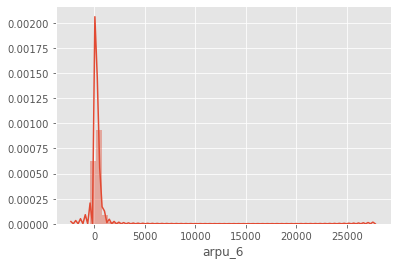

In [48]:
univariate(df.arpu_6)


count   69,999.0000
mean       191.0026
std        316.2706
min          0.0000
25%         34.3900
50%         91.8000
75%        216.4100
max     14,007.3400
Name: offnet_mou_8, dtype: float64


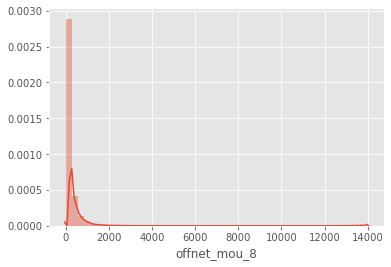

In [49]:
univariate(df.offnet_mou_8)


count   69,999.0000
mean       127.6417
std        304.3733
min          0.0000
25%          7.3600
50%         32.1000
75%        106.2800
max     10,752.5600
Name: onnet_mou_8, dtype: float64


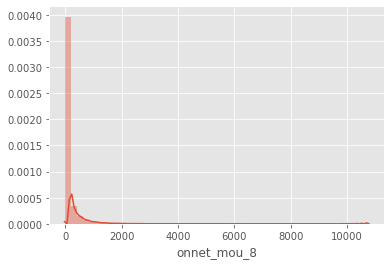

In [50]:
univariate(df.onnet_mou_8)


### Analyse some features from high value customers

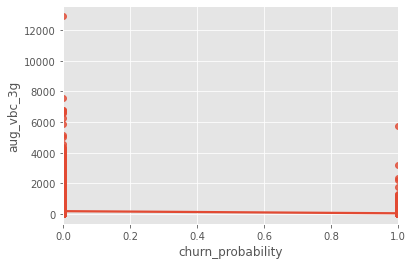

In [51]:
bivariate(dfh.churn_probability, dfh.aug_vbc_3g)

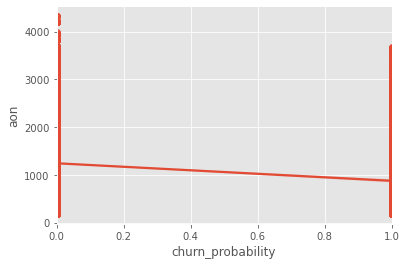

In [52]:
bivariate(dfh.churn_probability, dfh.aon)


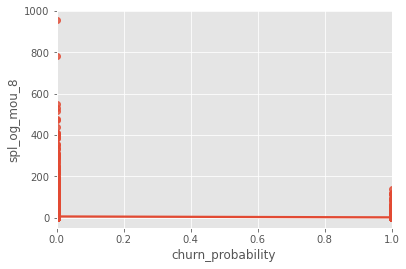

In [53]:
bivariate(dfh.churn_probability, dfh.spl_og_mou_8)


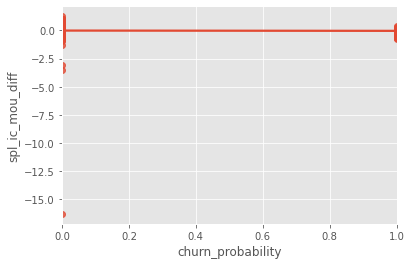

In [54]:
bivariate(dfh.churn_probability, dfh.spl_ic_mou_diff)


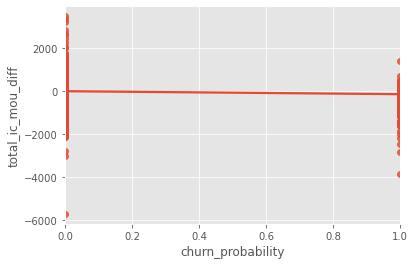

In [55]:
bivariate(dfh.churn_probability, dfh.total_ic_mou_diff )

### Because data is reduced we will use full data to predict churn

#### Observations after EDA:
- Calls Revenue(3 columns)
- Invalid Values : Having minimum values as negatives, indicating some customers are making loss to the company.    


- Minutes of usage(60+ columns):
- Usage minutes is generally 0 except for few outliers, for below variables:
- Roaming Incoming ISD Incoming Special Incoming Others STD incoming T2F STD outgoing T2F Outgoing Others ISD Outgoing Local Outgoing T2C (Customer care calls)  
  
- Most of the columns have outliers.  
  
- Aggregating Columns based on Incoming and Outgoing, or Aggregating based on Each Type of Incoming Calls and Outgoing Calls and looking at the metrics will give a better understanding of the data.
  
- Recharge (12 Numeric + 3 Date columns)
Data Type Conversion:  
- Data in numeric columns are integers, so can be converted to int type.
- Date columns need to be converted to date type
- Data 2G And 3G(22 Columns)
- Most of the columns have median as O and have outliers
  
  
- Age on Network (1 Column)
- Feature can be derived from AON column.
  
- Churn (Dependent Variable)
There exists a Class Imbalance in the dataset, where actual churn customers are only 10% of the dataset.
  
Feature Engineering - Thoughts
- Derive no. of years the customer is using network from AON
- Derive fields to indicate the type of user the customer is: Uses Both Calls and Data, Only Calls, Only Data, Only Incoming calls, Only Outgoing calls, etc.
- Bin the customers into different segments based on Service usage, Recharge amount, Usage/Recharge pattern.


In [56]:
df['aon'] = df['aon'] / 365
df['aon'].describe()
dft['aon'] = dft['aon'] / 365
dft['aon'].describe()


count   30,000.0000
mean         3.3370
std          2.6304
min          0.4932
25%          1.2767
50%          2.3370
75%          4.9178
max         11.4986
Name: aon, dtype: float64

### Deal with outliers

In [57]:
if HANDLE_OUTLIERS:
    for col in df.columns:
        if df[col].dtype == np.float64:
            df[col] = remove_outliers(df[col])
    print(df.shape)
    for col in dfh.columns:
        if dfh[col].dtype == np.float64:
            dfh[col] = remove_outliers(dfh[col])
    print(dfh.shape)
else:
    print('SKIP_OUTLIERS_HANDLING')

(69999, 184)
(21013, 184)


## Models

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

In [59]:
# divide data into train and test
y = df['churn_probability']
X = df.drop("churn_probability", axis = 1)

if USE_HIGH_CHURN:
    y = dfh['churn_probability']
    X = dfh.drop("churn_probability", axis = 1)
    print("Using high churn")


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 23, stratify = y)

In [61]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(62999, 183) (62999,) (7000, 183) (7000,)


 131:  99.5104
 132:  99.5357
 133:  99.5607
 134:  99.5856
 135:  99.6104
 136:  99.6340
 137:  99.6570
 138:  99.6798
 139:  99.7010
 140:  99.7210
 141:  99.7399
 142:  99.7577
 143:  99.7742
 144:  99.7896
 145:  99.8041
 146:  99.8178
 147:  99.8312
 148:  99.8437
 149:  99.8559
 150:  99.8666
 151:  99.8770
 152:  99.8869
 153:  99.8961
 154:  99.9048
 155:  99.9127
 156:  99.9201
 157:  99.9273
 158:  99.9344
 159:  99.9412
 160:  99.9476
 161:  99.9535
 162:  99.9593


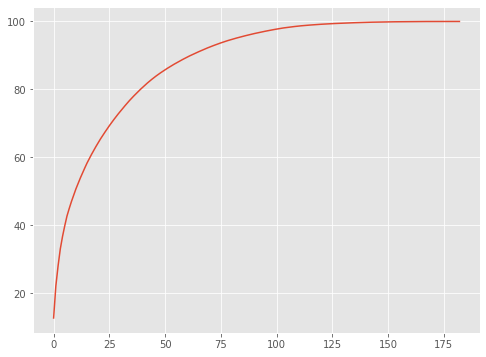

In [62]:
pcap = Pipeline([('sc', StandardScaler()), ('pca', PCA())])
pcap.fit(X_train)
i = 0
for ev in pcap['pca'].explained_variance_ratio_.cumsum():
    if ev > 0.995 and ev < 0.9996:
        print(f' {i+1}:  {ev*100.:.4f}')
    i+=1
# plot feature variance
stpca = range(pcap['pca'].n_components_)
cumulative_variance = np.round(np.cumsum(pcap['pca'].explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(8,6)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)
plt.show()

 17:  99.5713
 18:  99.6611
 19:  99.7196
 20:  99.7550
 21:  99.7806
 22:  99.8052
 23:  99.8243
 24:  99.8421
 25:  99.8591
 26:  99.8713
 27:  99.8815
 28:  99.8905
 29:  99.8990
 30:  99.9071
 31:  99.9138
 32:  99.9194
 33:  99.9243
 34:  99.9291
 35:  99.9335
 36:  99.9374
 37:  99.9408
 38:  99.9440
 39:  99.9470
 40:  99.9499
 41:  99.9527
 42:  99.9555
 43:  99.9582


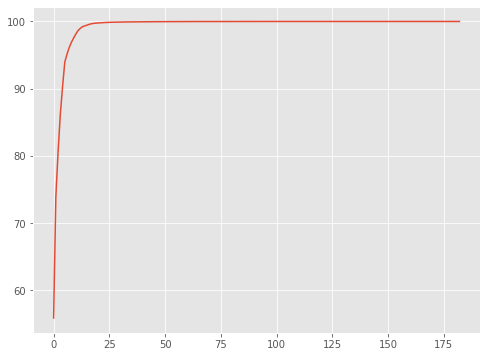

In [63]:
pcap = Pipeline([('rs', RobustScaler()), ('pca', PCA())])
pcap.fit(X_train)
i = 0
for ev in pcap['pca'].explained_variance_ratio_.cumsum():
    if ev > 0.995 and ev < 0.9996:
        print(f' {i+1}:  {ev*100.:.4f}')
    i+=1
# plot feature variance
stpca = range(pcap['pca'].n_components_)
cumulative_variance = np.round(np.cumsum(pcap['pca'].explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(8,6)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)
plt.show()

- RobustScaler gives 12 features with 99.5%
- StandardScaler gived 120 features with 99.5% explained variability

In [64]:
def show_results(mdl,xtrn, ytrn, xtest, ytest):
    results = pd.DataFrame()
    print("-"*50)
    print("Scores:")
    print(f'Train: {mdl.score(xtrn, ytrn):.4f} Test: {mdl.score(xtest, ytest):.4f}', )
    _y_pred = mdl.predict(xtest)
    print("-"*50)
    print("confusion_matrix")
    print(confusion_matrix(ytest, _y_pred))
    print("-"*50)
    print("classification_report")
    print(classification_report(ytest, _y_pred, target_names=['No Churn', 'Churn']))
    print("-"*50)
    
def predict_test(dfin, mdl, scl=None, ipca=None, csvf="rfpreds.csv", write=False):
    dfc = dfin.copy()
    if scl:
        print(f"Scaling")
        dfc = scl.transform(dfc)
    if ipca:
        print("PCA")
        dfc = ipca.transform(dfc)
    preds = mdl.predict(dfc)
    _dfr1 = pd.DataFrame()
    _dfr1['id'] = dftid['id']
    _dfr1['churn_probability'] = preds
    print(_dfr1['churn_probability'].value_counts() / _dfr1.shape[0])
    if write:
        _dfr1.to_csv(csvf, index=False)
    return preds

In [65]:
from lightgbm import LGBMClassifier
rbscaler = ('rbsc', RobustScaler())
smote = ('smote', SMOTE())

In [66]:
# oversample = SMOTE()
# X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)

In [67]:
all_models = {}

## Model 1 - Logistic Regression

In [68]:
lc = ('lgc', 
      LogisticRegression(class_weight="balanced",
                        random_state=23, 
                        n_jobs=N_JOBS,
                        verbose=VERBOSITY
                       ))

fpca = ('pca', PCA(130, random_state=23))
stscaler = ('stsc', StandardScaler())
lcpipe1 = Pipeline([stscaler, fpca, lc])
lcpipe1.fit(X_train, y_train)
all_models['logistic1'] = lcpipe1
show_results(lcpipe1, X_train, y_train, X_test, y_test)
plg = predict_test(dft, lcpipe1, csvf=PRED_FOLDER+'/logistic.csv')

--------------------------------------------------
Scores:
Train: 0.8229 Test: 0.8326
--------------------------------------------------
confusion_matrix
[[5210 1077]
 [  95  618]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.98      0.83      0.90      6287
       Churn       0.36      0.87      0.51       713

    accuracy                           0.83      7000
   macro avg       0.67      0.85      0.71      7000
weighted avg       0.92      0.83      0.86      7000

--------------------------------------------------
0   0.7398
1   0.2602
Name: churn_probability, dtype: float64


### First model has bad recall for No Churn
- But this model is very good at predicting Churn

## Model 2: We will try to improve first model

#### Use code below to get best value for Logistic regression

In [69]:
# params = {
#     "pca__n_components": [70, 100, 130],
#     "lgce__l1_ratio": [0.2, 0.5, 0.8]
# }
# lcpipe = Pipeline([rbscaler, fpca, lce])
# search = GridSearchCV(lcpipe, cv=5, param_grid=params, 
#                       scoring='roc_auc', 
# #                       n_jobs=N_JOBS, 
#                       verbose=1)
# search.fit(X_train, y_train)

# get_gridcv_results(search)

In [70]:
lceb = ('lgceb', 
      LogisticRegression(penalty="elasticnet", 
                        class_weight="balanced",
                        solver="saga",
                        l1_ratio=0.1,
                        random_state=23, 
                        n_jobs=N_JOBS,
                        verbose=VERBOSITY
                       ))
lcpipe2 = Pipeline([stscaler, ('pca', PCA(130, random_state=23)), lceb])
lcpipe2.fit(X_train, y_train)
all_models['logistic2_pca_elastic'] = lcpipe2
show_results(lcpipe2, X_train, y_train, X_test, y_test)
plg = predict_test(dft, lcpipe2, csvf=PRED_FOLDER+'/logistic_best.csv')

--------------------------------------------------
Scores:
Train: 0.8203 Test: 0.8290
--------------------------------------------------
confusion_matrix
[[5186 1101]
 [  96  617]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.98      0.82      0.90      6287
       Churn       0.36      0.87      0.51       713

    accuracy                           0.83      7000
   macro avg       0.67      0.85      0.70      7000
weighted avg       0.92      0.83      0.86      7000

--------------------------------------------------
0   0.7377
1   0.2623
Name: churn_probability, dtype: float64


### Not much improvement is seen

## Model 3: We try without PCA

In [71]:
lcpipe_no_rca = Pipeline([stscaler, lceb])
lcpipe_no_rca.fit(X_train, y_train)
all_models['logistic3_nopca_elastic'] = lcpipe_no_rca
show_results(lcpipe_no_rca, X_train, y_train, X_test, y_test)
plg = predict_test(dft, lcpipe_no_rca, csvf=PRED_FOLDER+'/logistic_best_no_rca.csv')

--------------------------------------------------
Scores:
Train: 0.8371 Test: 0.8443
--------------------------------------------------
confusion_matrix
[[5291  996]
 [  94  619]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.98      0.84      0.91      6287
       Churn       0.38      0.87      0.53       713

    accuracy                           0.84      7000
   macro avg       0.68      0.85      0.72      7000
weighted avg       0.92      0.84      0.87      7000

--------------------------------------------------
0   0.7568
1   0.2432
Name: churn_probability, dtype: float64


### Only a slight improvement is seen

Logistic regression is not a good model choice
- Overall accuracy is only 86%
- It has good recall for Churn 
- but this sacrifices accuracy for Churn probability
## In our case Recall for Churn is important 
### So we could use the first model
### But this will result in unwanted promotions to people who do not want to churn

## Model 4: Random forest without PCA
### Because we want feature importance

In [72]:
rfca = ('rfc', RandomForestClassifier(
    n_estimators=100, 
    bootstrap=True, criterion="entropy", 
    max_features=0.1, 
    class_weight="balanced",
    min_samples_leaf=55, # 19,
    n_jobs=N_JOBS, verbose=VERBOSITY))
                                      
rfcam5 = Pipeline([rfca])
rfcam5.fit(X_train, y_train)
all_models['rf2_pca'] = rfcam5
show_results(rfcam5, X_train, y_train, X_test, y_test)
plg = predict_test(dft, rfcam5, csvf=PRED_FOLDER+'/random_final.csv',write=False)

--------------------------------------------------
Scores:
Train: 0.9249 Test: 0.9190
--------------------------------------------------
confusion_matrix
[[5838  449]
 [ 118  595]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.98      0.93      0.95      6287
       Churn       0.57      0.83      0.68       713

    accuracy                           0.92      7000
   macro avg       0.78      0.88      0.82      7000
weighted avg       0.94      0.92      0.93      7000

--------------------------------------------------
0   0.8508
1   0.1492
Name: churn_probability, dtype: float64


- This model has a little more balanced. 
#### We can use it to find feature importance

- Random forest is very good at predicting No Churn: 93% Recall
- But this is not useful to us
- Recall for Churn is 83% 
- This is a good balance between churn and No Churn

### Find important features

In [73]:
features = dfh.drop('churn_probability', axis=1).columns
# feature_importance
importance = rfcam5['rfc'].feature_importances_
rfi = get_feature_importance(rfcam5['rfc'], features)

top_20rf = rfi['variables'][:20]
rfi.head(20)

Sum of importance= 100.0


,variables,importance_percentage,cumulative_importance
0,total_ic_mou_8,10.3647,10.3647
1,total_og_mou_8,6.9501,17.3148
2,last_day_rch_amt_8,5.5603,22.8751
3,loc_ic_t2m_mou_8,4.7911,27.6663
4,loc_ic_mou_8,4.1144,31.7807
5,arpu_8,4.0146,35.7953
6,max_rech_amt_8,3.9575,39.7528
7,total_rech_amt_8,3.4632,43.2160
8,loc_og_t2m_mou_8,2.8282,46.0441
9,loc_ic_t2t_mou_8,2.7390,48.7831


### Plot most important features again

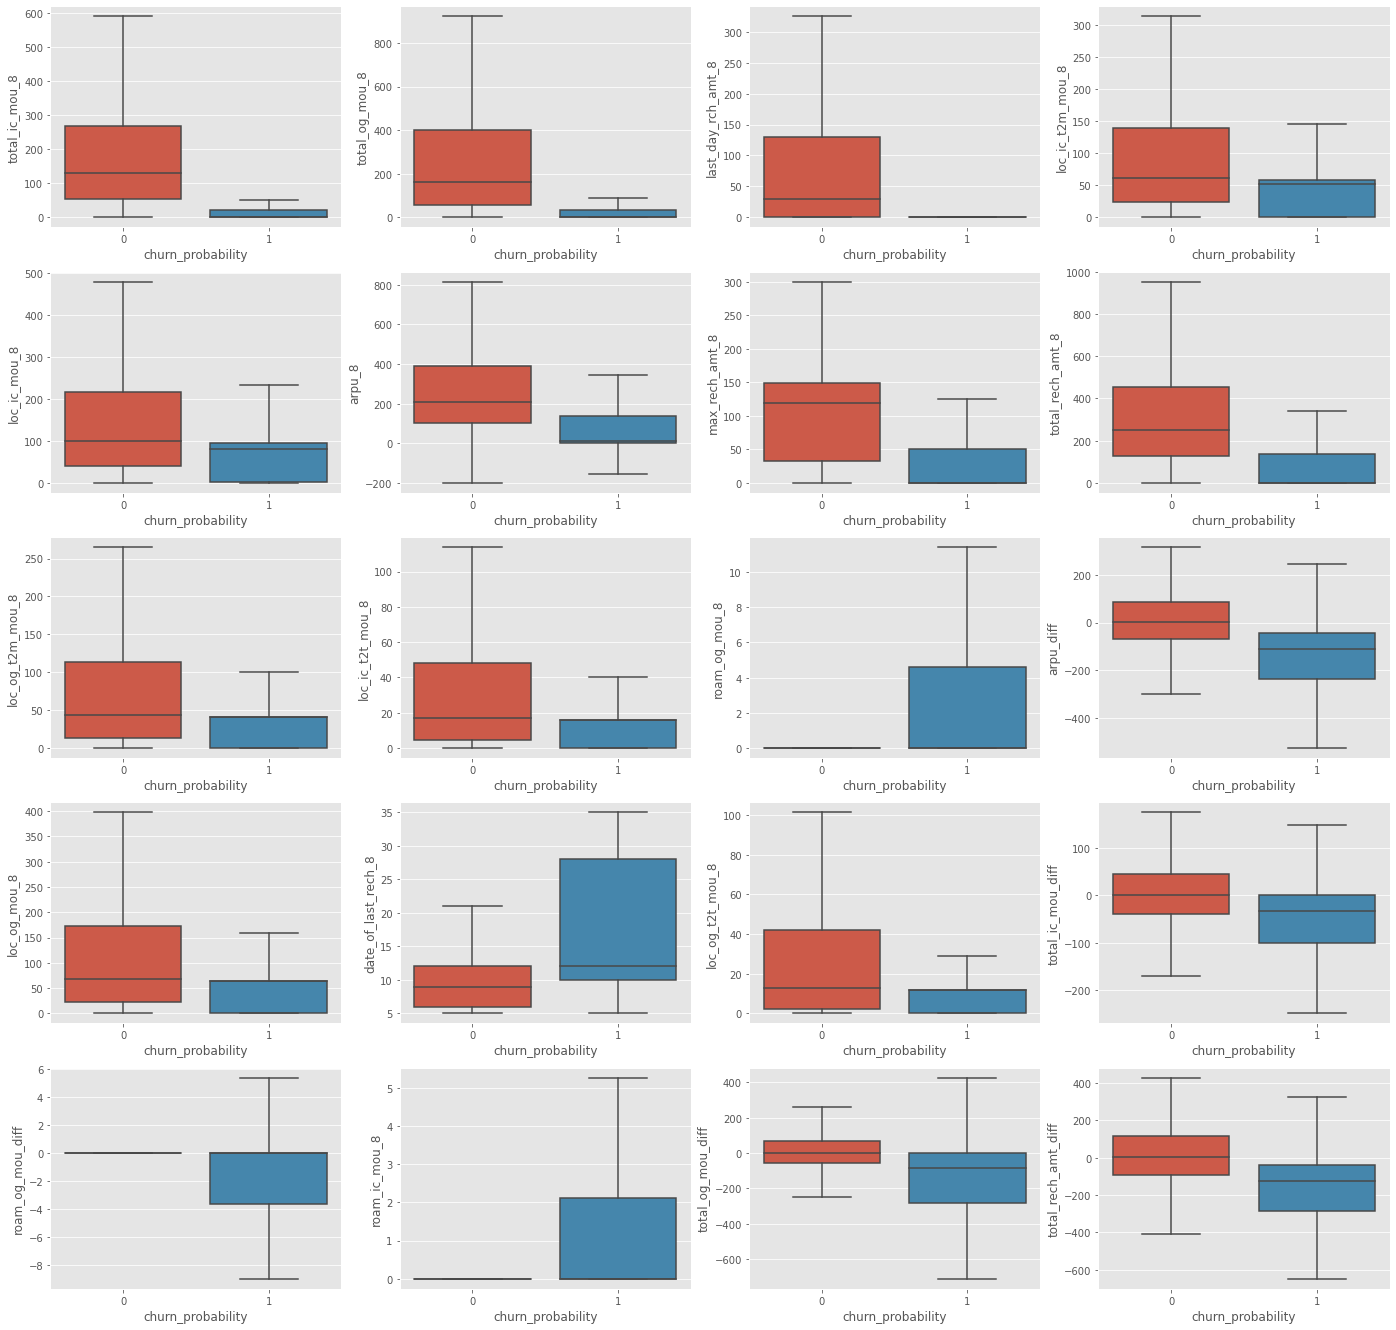

In [74]:
plt.figure(figsize=(24, 48))
i = 0
dfch = df.copy()
for col in top_20rf:  
    i+=1
    plt.subplot(10,4,i)
    sns.boxplot(df['churn_probability'], df[col], showfliers=False)
plt.show()


## Recommendations
Overall, the more the user uses the service, lower the chance of churn.
 	
	
|Features|Interpretation|
|---|---|
|All ic, og \_mou_8|Total incoming and outgoing calls of ALL types are low|
|total_rech_amt_8, max_rech_amt_8|Total and max Recharge amout drops|
|last_day_rch_amt_8|Last day recharge amount is zero|
|All \_diff|All \_diff are negative - showing drop in usage compared to last 2 months|
|arpu_8|Average revenue drops|
|date_of_last_rech_8|Days since last recharge are high|
  
All top features are for last month usage.

#### Customers who are about the churn have:
- low incoming and outgoing mous - overall usage drops
- They have not recharged in the last month
- Previous recharge amounts are also less than other customers
- Average revenue per user is almost zero
- More Days since last recharge show higher churn probability
- All usage indicators are less than other usage indicators

### Let us see if we can improve Prediction of Churn
### We will try LightGBM

##### Gridsearch is commented out - because it takes long time to run

In [75]:
# params = {
#     'lgbm__n_estimators': [600, 800, 1000],
#     'lgbm__learning_rate': [0.05, 0.1, 0.15],
#     'lgbm__subsample': [0.5, 0.7, 0.9],
#     'lgbm__min_child_samples': [25, 55, 85]
#     'lgbm__reg_alpha': [50, 100, 150]
# }
# # lgbmp = Pipeline([('lgbm', LGBMClassifier(boosting_type="goss", class_weight = "balanced"))])
# lgbmp = Pipeline([lgbc])
# lgmdl = GridSearchCV(lgbmp, cv=3, param_grid=params, 
#                       scoring='roc_auc', 
# #                       n_jobs=N_JOBS, 
#                       verbose=2)
# lgmdl.fit(X_train, y_train)
# get_gridcv_results(lgmdl)

# Best params from CV
# n_estimators=600,
# learning_rate = 0.05,
# min_child_samples=5,
# class_weight = "balanced",
# subsample = 0.8,

## Model 5 - LightGBM

In [76]:
lgbest = ('lgbm', LGBMClassifier(
    n_estimators=800, # 600 1500
    boosting_type="goss", 
    learning_rate = 0.12, # .015
    min_child_samples=55,
    reg_alpha=150,
    class_weight = "balanced",
    subsample = 0.7,
    random_state = 23,
    n_jobs = N_JOBS
                     ))
lgbpipe = Pipeline([lgbest])
lgbpipe.fit(X_train, y_train)
show_results(lgbpipe, X_train, y_train, X_test, y_test)
plg = predict_test(dft, lgbpipe, csvf=PRED_FOLDER+'/submission.csv', 
                   write=CREATE_SUBMISSION_CSV)

--------------------------------------------------
Scores:
Train: 0.9112 Test: 0.9097
--------------------------------------------------
confusion_matrix
[[5741  546]
 [  86  627]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.99      0.91      0.95      6287
       Churn       0.53      0.88      0.66       713

    accuracy                           0.91      7000
   macro avg       0.76      0.90      0.81      7000
weighted avg       0.94      0.91      0.92      7000

--------------------------------------------------
0   0.8260
1   0.1740
Name: churn_probability, dtype: float64


#### Models summary:

|Model|PCA|Accuracy|Churn Recall|No Churn Recall|Accuracy on Test Set|
|---|---|---|---|---|---|
|__LightGBM__|No|92|__88__|__91__|90.3|
|RandomForest|No|93|83|93|91.4|
|RandomForest2|No|94|74|97|94.1|
|Logistic Regression|No|87|87|84|82.8|
|Logistic Regression|Yes|86|87|82|Not Submitted|
  
  
##### LightGBM gives best balance between churn and no churn recall over Random Forrest and Logistic Regression
- Using PCA improved training time, but reducded Accuracy
- All models performed better without PCA

#### Important metric - recall for churn
- For this case study, we will choose recall as the most important metric
- The data has class imbalance, data for churn is only 10% of available data
- This makes it difficult to predict churn
- Hence the model we choose must have high recall for churn


## Recommended models
#### We sacrifice overall accuracy to get higher recall for churn_probability
#### LightGBM is recommended for prediction of churn
##### We will not use PCA, because both models performed better without PCA

## Recommendations about churn
Overall, the more the user uses the service, lower the chance of churn.
 	
	
|Features|Interpretation|
|---|---|
|All ic, og \_mou_8|Total incoming and outgoing calls of ALL types are low|
|total_rech_amt_8, max_rech_amt_8|Total and max Recharge amout drops|
|last_day_rch_amt_8|Last day recharge amount is zero|
|All \_diff|All \_diff are negative - showing drop in usage compared to last 2 months|
|arpu_8|Average revenue drops|
|date_of_last_rech_8|Days since last recharge are high|
  
All top features are for last month usage.  
Company should monitor last month usage closely.

#### Customers who are about the churn have following characteristics:
- low incoming and outgoing mous - overall usage drops
- They have not recharged in the last month
- Previous recharge amounts are also less than other customers
- Average revenue per user is almost zero
- More Days since last recharge show higher churn probability
- All usage indicators are less than other usage indicators

## Other Models

In [77]:
rfca1 = ('rfc', 
        RandomForestClassifier(n_estimators=200, 
                             max_depth=21, 
                             class_weight="balanced_subsample",
                             min_samples_leaf=7,
                             random_state=23, 
                             n_jobs=10,
                             verbose=VERBOSITY)
        )
                                      
rfcam51 = Pipeline([rfca1])
rfcam51.fit(X_train, y_train)
all_models['rf2_pca'] = rfcam51
show_results(rfcam51, X_train, y_train, X_test, y_test)
plg = predict_test(dft, rfcam51, csvf=PRED_FOLDER+'/random_final_high.csv',write=False)
# Accuracy 0.94093

--------------------------------------------------
Scores:
Train: 0.9702 Test: 0.9444
--------------------------------------------------
confusion_matrix
[[6086  201]
 [ 188  525]]
--------------------------------------------------
classification_report
              precision    recall  f1-score   support

    No Churn       0.97      0.97      0.97      6287
       Churn       0.72      0.74      0.73       713

    accuracy                           0.94      7000
   macro avg       0.85      0.85      0.85      7000
weighted avg       0.94      0.94      0.94      7000

--------------------------------------------------
0   0.8963
1   0.1037
Name: churn_probability, dtype: float64
